# PyDESeq2 Analysis

This is the Python version of the popular DESeq2 package in R for differential gene expression analysis.
DESeq2 is widely used for bulk RNA-seq count data, offering robust statistical methods to identify genes that are differentially expressed between experimental conditions.
The goal is to take raw count data, normalize it, and extract insights from significant changes in gene expression.

In [1]:
## Load the bulk RNA-Seq data
# Here we have the raw counts, which is the exact input we want for DESeq2.
# Raw counts are generated by tools such as featureCounts or HTSeq-count.
from pathlib import Path
import pandas as pd

counts_path = Path("..") / "data" / "GSE164073_raw_counts_GRCh38.p13_NCBI.tsv.gz"
counts = pd.read_csv(counts_path, sep="\t")  # pandas auto-detects .gz compression

# Observe the data
counts.head()

,GeneID,GSM4996084,GSM4996085,GSM4996086,GSM4996087,GSM4996088,GSM4996089,GSM4996090,GSM4996091,GSM4996092,GSM4996093,GSM4996094,GSM4996095,GSM4996096,GSM4996097,GSM4996098,GSM4996099,GSM4996100,GSM4996101
0,100287102,2,5,3,2,5,2,4,2,3,2,2,4,3,2,2,3,3,3
1,653635,244,236,337,266,317,226,303,196,219,202,168,201,235,221,270,262,234,314
2,102466751,25,17,34,22,24,19,23,15,21,15,19,22,15,17,16,18,17,23
3,107985730,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,100302278,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [2]:
import numpy as np

# Set rownames to gene identifiers and make a numeric matrix
# (The input `counts` is the DataFrame loaded in your first cell.)
count_mat = (
    counts
    .rename(columns={counts.columns[0]: "GeneID"})   # ensure first col name
    .set_index("GeneID")
)
# Coerce to integers (raw counts)
count_mat = count_mat.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

print(count_mat.head())

samples = count_mat.columns.tolist()
sample_info = pd.DataFrame(
    {
        "tissue": np.repeat(["Cornea", "Limbus", "Sclera"], repeats=6),
        "condition": np.tile(np.repeat(["mock", "CoV2"], 3), 3),
        "replicate": np.tile(np.arange(1, 4), 6),
    },
    index=samples,
)
# Categorical factors (recommended for model formulas)
for col in ["tissue", "condition"]:
    sample_info[col] = sample_info[col].astype("category")

# Double-check alignment (rows of metadata == columns of counts)
assert list(sample_info.index) == samples, "Sample order mismatch."
display(sample_info)  # if in notebook

           GSM4996084  GSM4996085  GSM4996086  GSM4996087  GSM4996088  \
GeneID                                                                  
100287102           2           5           3           2           5   
653635            244         236         337         266         317   
102466751          25          17          34          22          24   
107985730           1           1           1           0           0   
100302278           0           0           0           0           0   

           GSM4996089  GSM4996090  GSM4996091  GSM4996092  GSM4996093  \
GeneID                                                                  
100287102           2           4           2           3           2   
653635            226         303         196         219         202   
102466751          19          23          15          21          15   
107985730           0           1           0           0           0   
100302278           0           0           0     

,tissue,condition,replicate
GSM4996084,Cornea,mock,1
GSM4996085,Cornea,mock,2
GSM4996086,Cornea,mock,3
GSM4996087,Cornea,CoV2,1
GSM4996088,Cornea,CoV2,2
GSM4996089,Cornea,CoV2,3
GSM4996090,Limbus,mock,1
GSM4996091,Limbus,mock,2
GSM4996092,Limbus,mock,3
GSM4996093,Limbus,CoV2,1


In [3]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# PyDESeq2 expects samples x genes → transpose
counts_df = count_mat.T

# Filter genes with at least 10 reads total (same as R)
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

# Create and fit the dataset (controls for tissue + tests condition)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=sample_info,
    design="~ tissue + condition",
)
dds.deseq2()  # fits size factors, dispersions, and LFCs

print(dds)  # AnnData-like summary

c:\Users\dekel\bioinformatics-code-hub\.venv\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.43 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 1.78 seconds.

Fitting LFCs...


AnnData object with n_obs × n_vars = 18 × 23713
    obs: 'tissue', 'condition', 'replicate'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'


... done in 1.29 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.55 seconds.



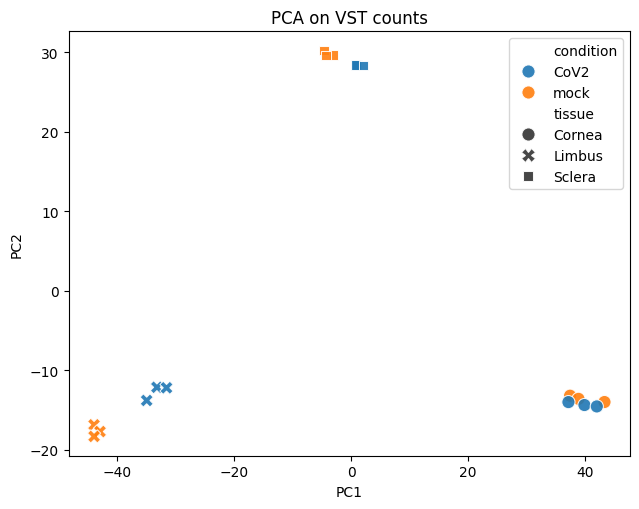

In [4]:
# VST using the design (analog of blind=FALSE in DESeq2)
dds.vst(use_design=True)
vst_counts = pd.DataFrame(
    dds.layers["vst_counts"],
    index=dds.obs.index,           # samples
    columns=dds.var.index,         # genes
)

# PCA plot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(vst_counts.values)
pc_df = pd.DataFrame(pcs, columns=["PC1", "PC2"], index=vst_counts.index).join(sample_info)

plt.figure(figsize=(6.5, 5.2))
sns.scatterplot(
    data=pc_df,
    x="PC1", y="PC2",
    hue="condition", style="tissue", s=90, alpha=0.9
)
plt.title("PCA on VST counts")
plt.tight_layout()
plt.show()

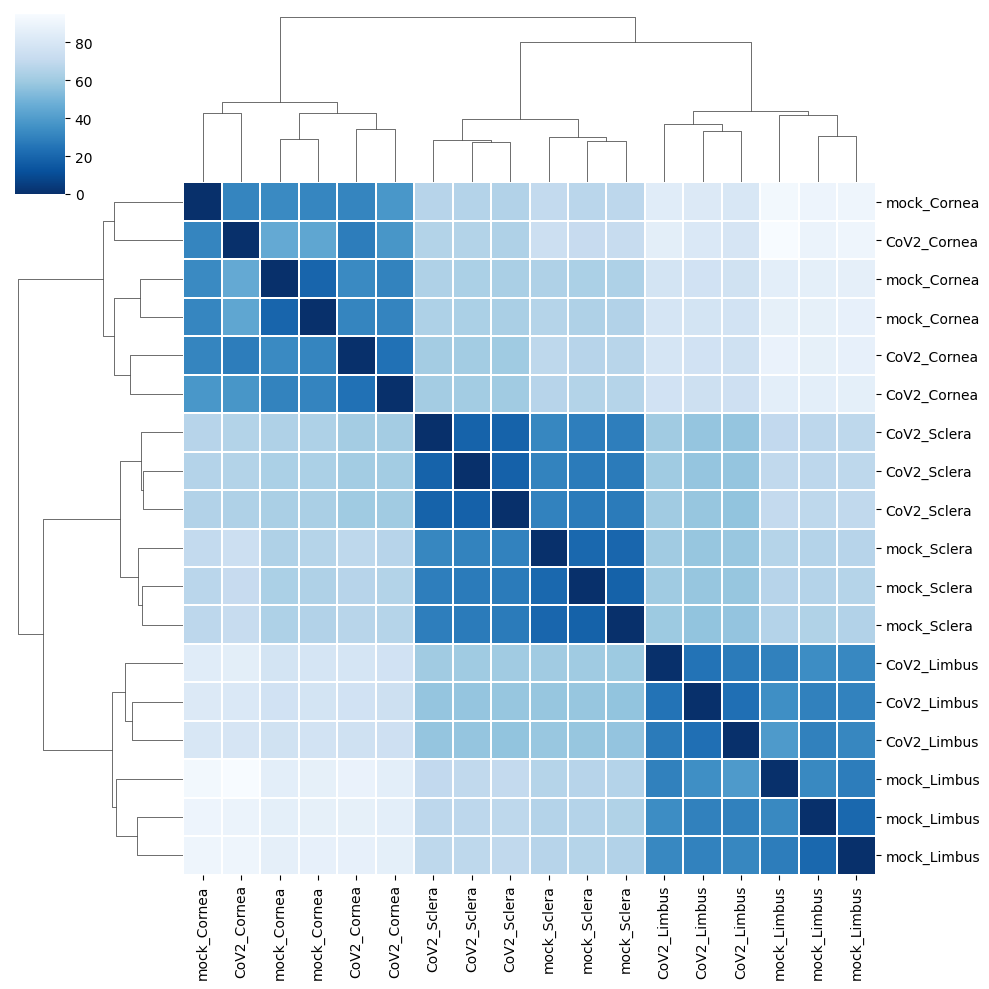

In [5]:

# Sample distance heatmap (Euclidean on VST)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

dists = pdist(vst_counts.values, metric="euclidean")
dist_mat = pd.DataFrame(
    squareform(dists),
    index=[f"{r.condition}_{r.tissue}" for _, r in sample_info.iterrows()],
    columns=[f"{r.condition}_{r.tissue}" for _, r in sample_info.iterrows()],
)

row_link = linkage(dists, method="average")
col_link = linkage(dists, method="average")

sns.clustermap(
    dist_mat, row_linkage=row_link, col_linkage=col_link,
    cmap="Blues_r", linewidths=0.2
)
plt.show()

In [6]:
ds = DeseqStats(dds, contrast=["condition", "CoV2", "mock"])
ds.summary()  # prints a summary similar to DESeq2

res = ds.results_df.sort_values("padj", na_position="last")
print(res.head())

Running Wald tests...


Log2 fold change & Wald test p-value: condition CoV2 vs mock
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneID                                                                  
100287102      2.835657        0.102710  0.468190  0.219377  0.826356   
653635       244.438406        0.038326  0.080807  0.474288  0.635295   
102466751     19.888426        0.074572  0.186789  0.399233  0.689721   
100996442     34.485168        0.136034  0.159334  0.853767  0.393234   
729737        57.110705        0.178675  0.165959  1.076625  0.281648   
...                 ...             ...       ...       ...       ...   
4541       27189.570155        0.001971  0.066087  0.029828  0.976204   
4556        1882.362584       -0.020218  0.088188 -0.229259  0.818668   
4519       99284.717086        0.138279  0.056214  2.459889  0.013898   
4576          79.560740       -0.045893  0.105097 -0.436676  0.662347   
4571         757.698879        0.177378  0.079302  2.236729  0.

... done in 1.26 seconds.



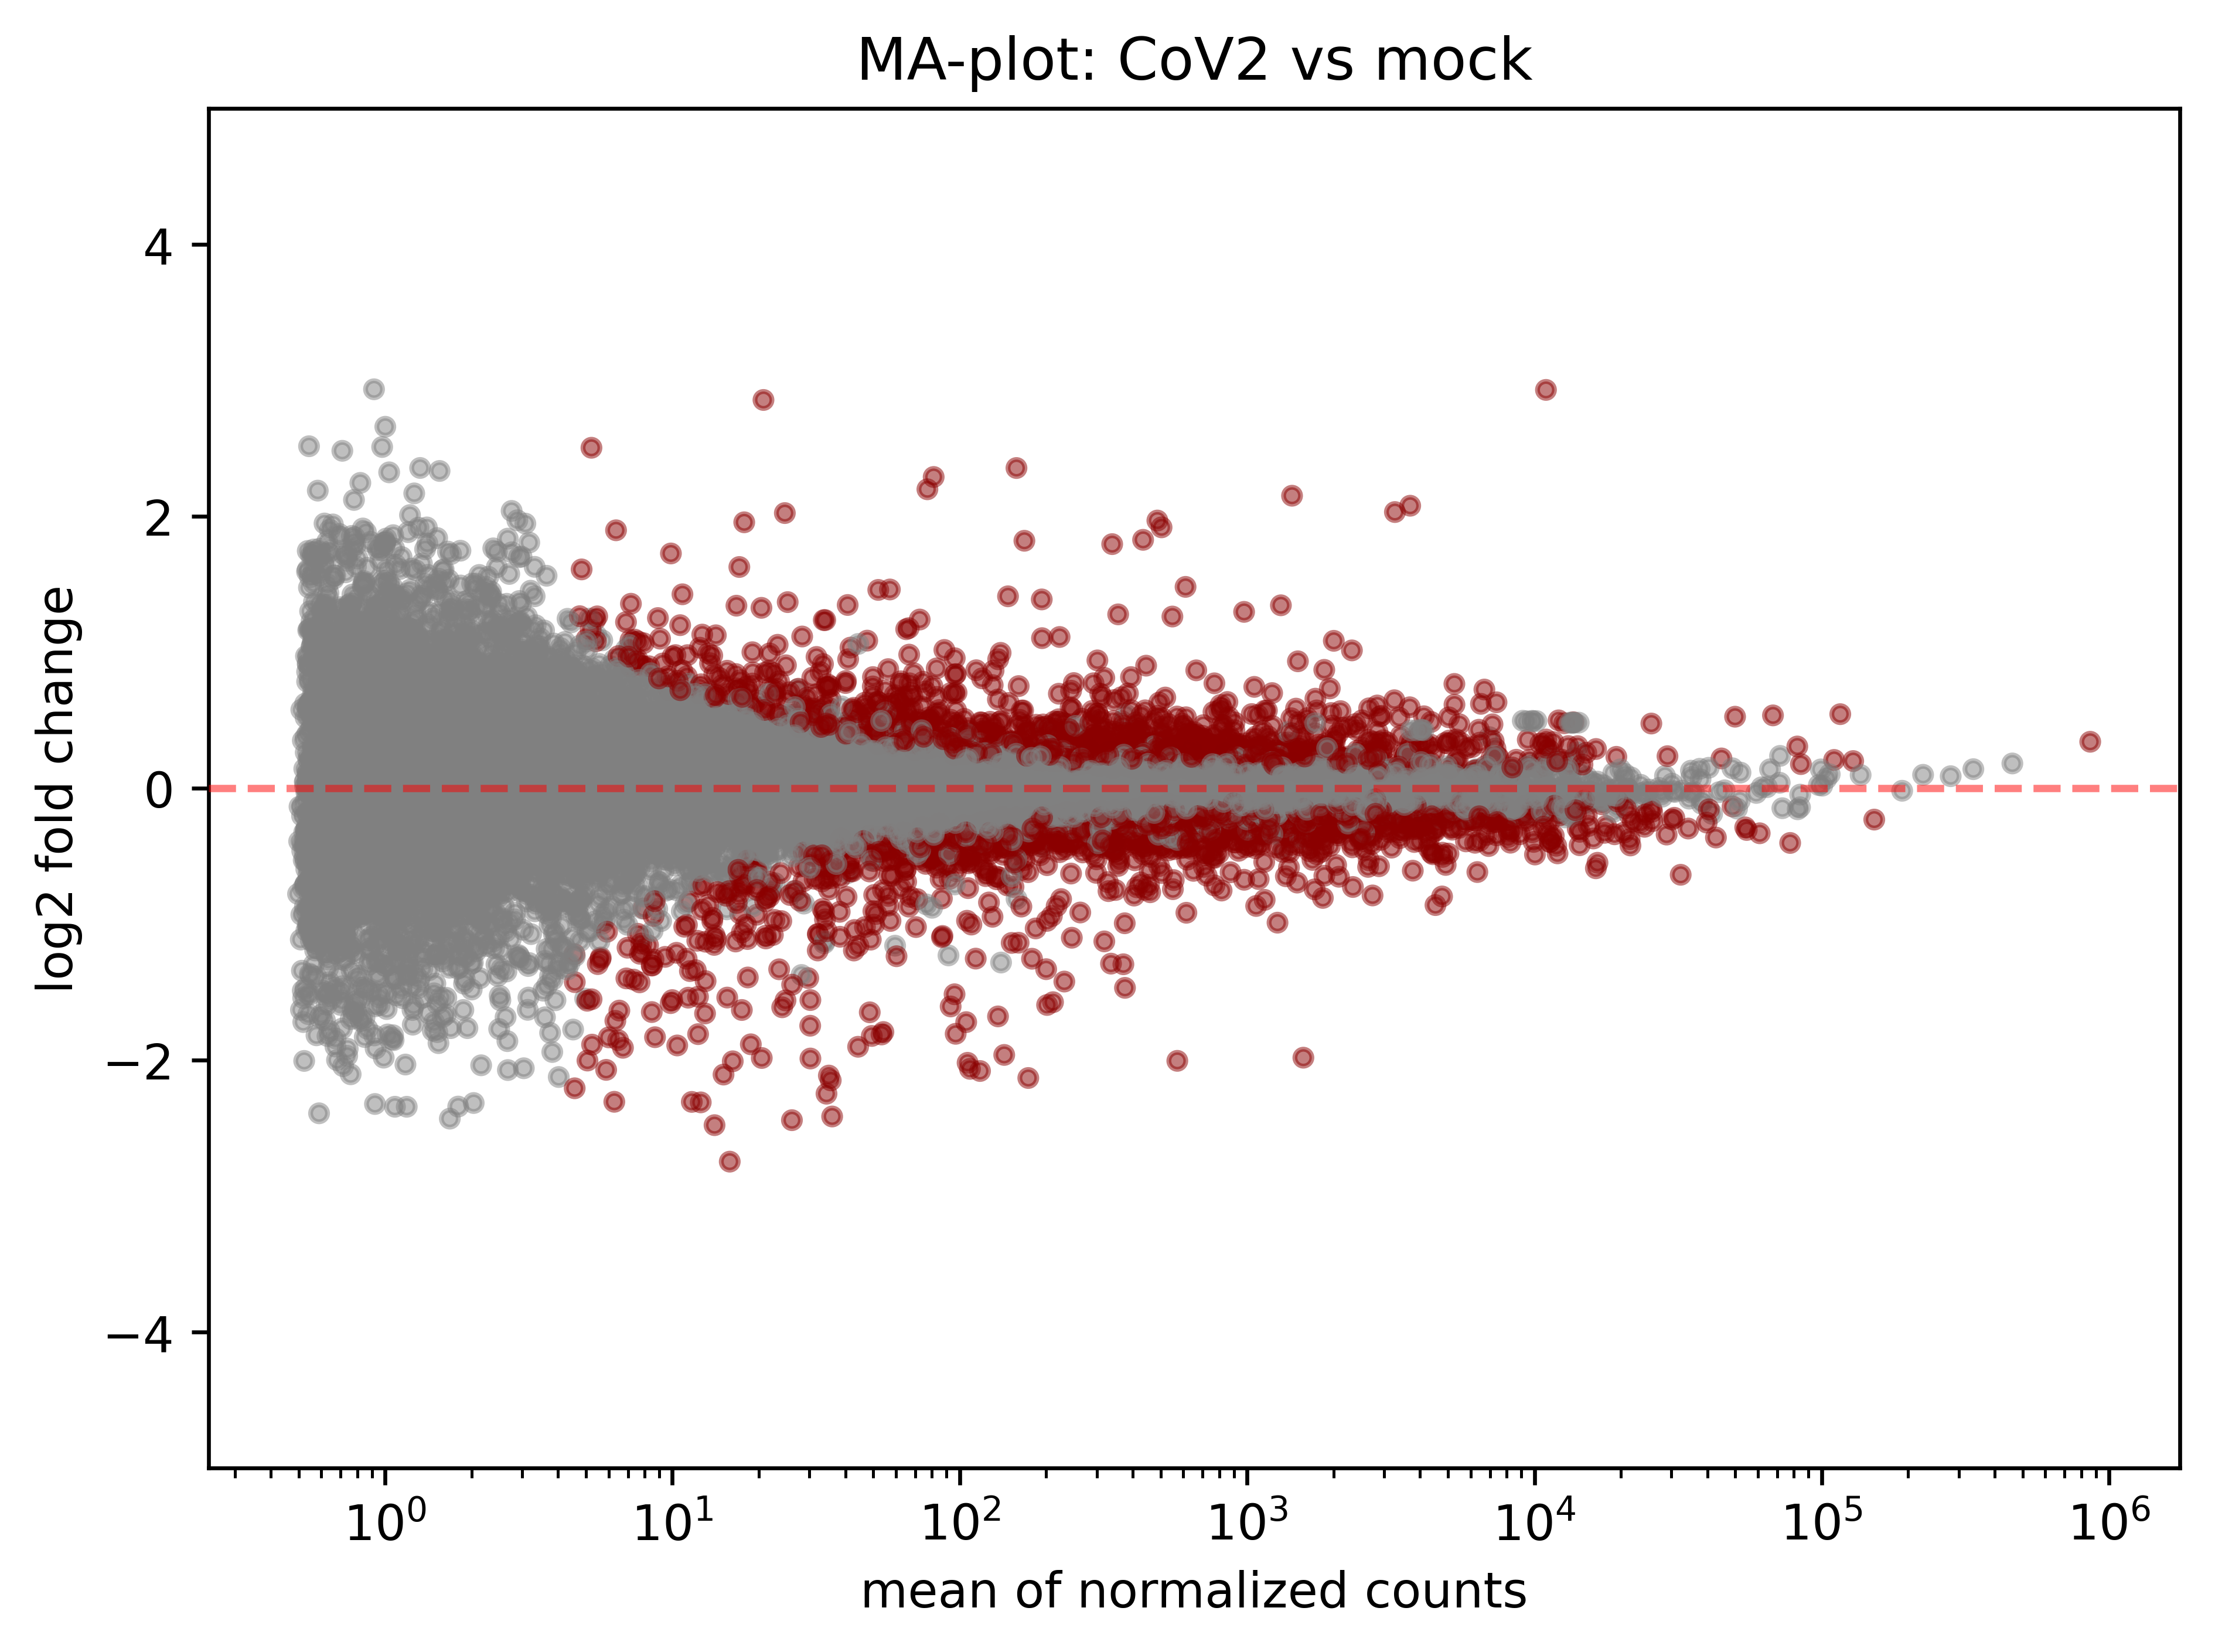

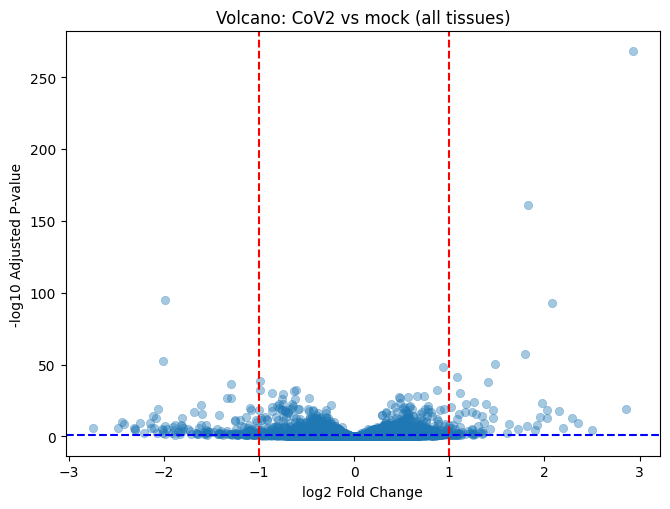

In [7]:
# MA plot (PyDESeq2 has a built-in version)
ds.plot_MA(s=12)
plt.ylim(-5, 5)
plt.title("MA-plot: CoV2 vs mock")
plt.tight_layout()
plt.show()

# Volcano plot
volc = res.copy()
# handle p-adj zeros / NaNs for plotting
volc = volc.replace([np.inf, -np.inf], np.nan).dropna(subset=["padj", "log2FoldChange"])
volc["neglog10_padj"] = -np.log10(volc["padj"].clip(lower=1e-300))
volc["gene"] = volc.index

plt.figure(figsize=(6.8, 5.2))
sns.scatterplot(data=volc, x="log2FoldChange", y="neglog10_padj", alpha=0.4, edgecolor=None)
plt.axvline(-1, ls="--", c="red"); plt.axvline(1, ls="--", c="red")
plt.axhline(-np.log10(0.05), ls="--", c="blue")
plt.xlabel("log2 Fold Change"); plt.ylabel("-log10 Adjusted P-value")
plt.title("Volcano: CoV2 vs mock (all tissues)")
plt.tight_layout()
plt.show()